In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import os.path
import networkx as nx

%matplotlib inline

In [2]:
# Define paths of the files
data_folder = os.path.join('.','data')
artists_path = os.path.join(data_folder,'artists.dat')
ratings_path = os.path.join(data_folder,'user_artists.dat')
tags_path = os.path.join(data_folder,'tags.dat')
tags_assign_path = os.path.join(data_folder,'user_taggedartists-timestamps.dat')

artists = pd.read_csv(artists_path, sep='\t', header=0, index_col=0, skipinitialspace=True)
ratings = pd.read_csv(ratings_path, sep='\t', header=0, skipinitialspace=True)
tags = pd.read_csv(tags_path, sep='\t', header=0, index_col=0, skipinitialspace=True, encoding='latin1')
tags_assign = pd.read_csv(tags_assign_path, sep='\t', header=0, skipinitialspace=True)

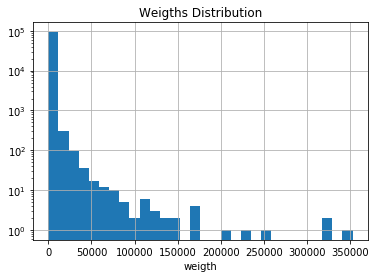

In [20]:
weights = ratings.weight

# Weigths Distribution
ax = plt.figure().gca();
weights.hist(ax=ax, bins=30, log=True);
ax.set_title('Weigths Distribution');
ax.set_xlabel('weigth');

24  users to drop


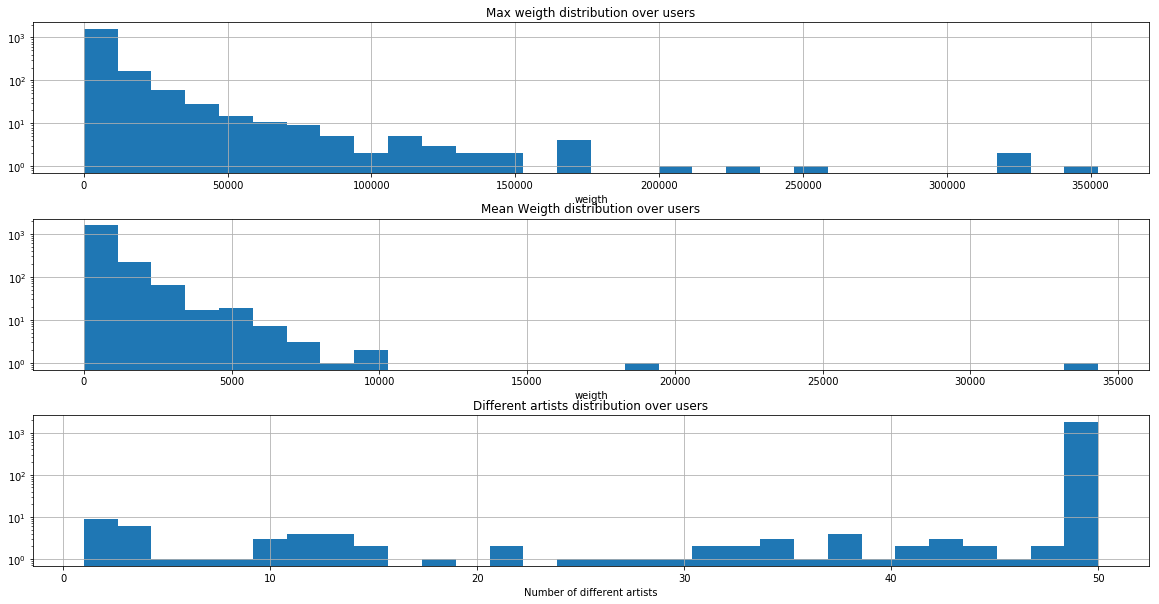

In [166]:
users_to_drop = set()

# Find weight distribution and mean for each user
users = ratings.groupby('userID')

_, [ax1,ax2,ax3] = plt.subplots(3,1, figsize=(20,10))

# Plot max
data = users.max()
data.hist(ax=ax1, column='weight', bins=30, log=True);
ax1.set_title('Max weigth distribution over users');
ax1.set_xlabel('weigth');
# Select users to drop based on the plotted histogram
users_to_drop.update(data[data.weight > 200000].index)

# Plot mean
data = users.mean()
data.hist(ax=ax2, column='weight', bins=30, log=True);
ax2.set_title('Mean Weigth distribution over users');
ax2.set_xlabel('weigth');
# Select users to drop based on the plotted histogram
users_to_drop.update(data[data.weight > 15000].index)

# Plot number of different artists users listened to
data = users.nunique().artistID
data.hist(ax=ax3, bins=30, log=True);
ax3.set_title('Different artists distribution over users');
ax3.set_xlabel('Number of different artists');
# Select users to drop based on the plotted histogram
users_to_drop.update(data[data<10].index)

# Plot var
#data = users.var()
#data.sort_values('weight', inplace=True)
#ax3.semilogy(np.arange(len(data)), data.weight)
#ax3.set_title('Variance for each user');
#ax3.set_xlabel('weigth');

print(len(users_to_drop), ' users to drop')

We decided to remove users with weights much higher than the others trying to obtain a "smooth" distribution. We don't know the meaning of such high weights, but they are clearly outliers that could negatively affect our statistics.
On the other end we decided also to remove the users who listened to less than 10 different artists. This kind of users could be new users or single-artist-listener which are not very useful to build a network for collaborative filtering.

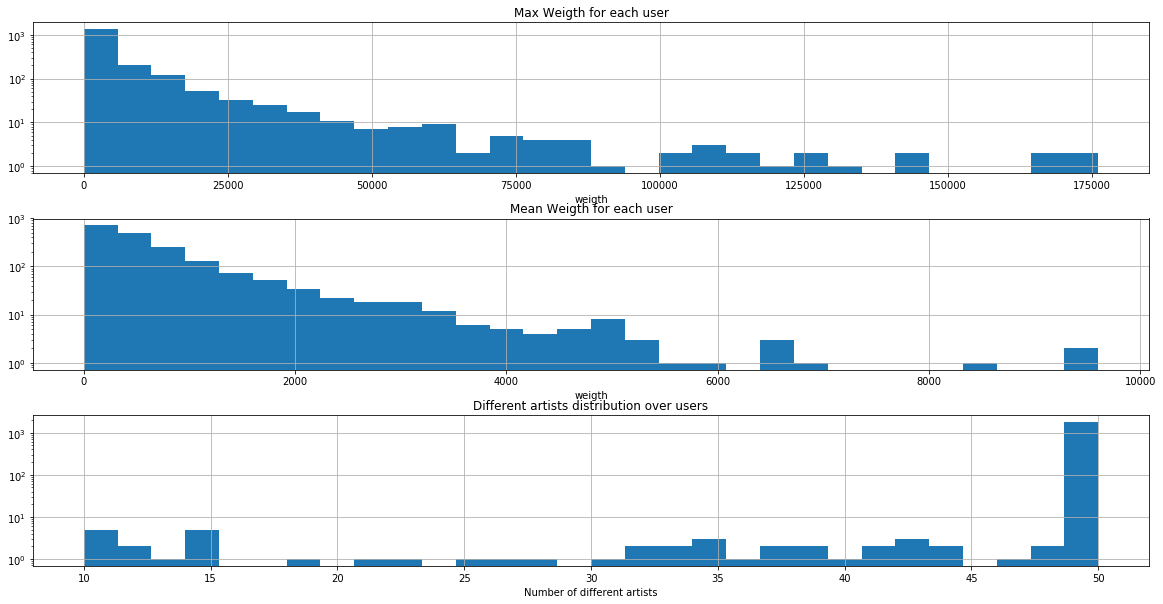

In [169]:
# Prune ratings
pruned = ratings.copy()
for u in users_to_drop:
    pruned = pruned[pruned.userID != u]
    
# Plot again
users = pruned.groupby('userID')

_, [ax1,ax2,ax3] = plt.subplots(3,1, figsize=(20,10))

data = users.max()
data.hist(ax=ax1, column='weight', bins=30, log=True);
ax1.set_title('Max Weigth for each user');
ax1.set_xlabel('weigth');

data = users.mean()
data.hist(ax=ax2, column='weight', bins=30, log=True);
ax2.set_title('Mean Weigth for each user');
ax2.set_xlabel('weigth');

data = users.nunique().artistID
data.hist(ax=ax3, bins=30, log=True);
ax3.set_title('Different artists distribution over users');
ax3.set_xlabel('Number of different artists');

### Weight Normalization
We need to build a similarity graph for collaborative filtering. We need to understand which artists users listen to and not necessarely how much. Even though taking into account the absolute value of listening counts could have been a measure of how much we can trust a user preferences, we decided to normalize separately for each user in order to keep the weights simple and clear. In particular we model the normalized weight as the probability of a certain user to listen to an artist. Thus, all the weights of a user sum to 1.

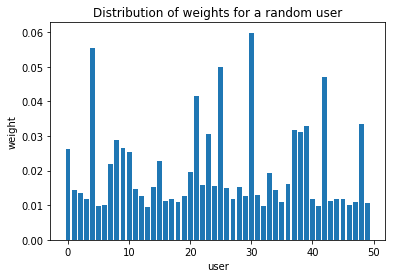

In [233]:
# Normalize weights for each user
users = pruned[['userID', 'weight']].groupby('userID')
tots = users.sum().weight.to_dict()

normalized = pruned.copy()
normalized.weight = normalized.weight / [tots[i] for i in normalized.userID]

# Plot distribution of weights for a random user
np.random.seed(1)
user = np.random.choice(normalized.userID)
y = normalized[normalized.userID == user].weight
plt.bar(np.arange(len(y)), y);
plt.title('Distribution of weights for a random user');
plt.xlabel('user');
plt.ylabel('weight');